In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import time

from data.tinyimagenet import TinyImageNet

from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps


from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image_on_ax
from our_modules.plot_tools import EpsExperimentPlot
from our_modules.plot_tools import IdOodPlot
from our_modules.plot_tools import plot_diff_stats_for_eps

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import get_model_for_split
from our_modules.tin_tools import transform_range as tin_transform_range

from our_modules.adv_tools import fn_osr_fgsm, fp_osr_fgsm, fn_osr_fgsm_log_msp



### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


# Tinyimagenet

In [5]:
tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
tin_goldfish = tin_dataset[9][0]
tin_grad_norm_dir = root_dir + 'grad_norms/tinyimagenet/'

### Eps experiments

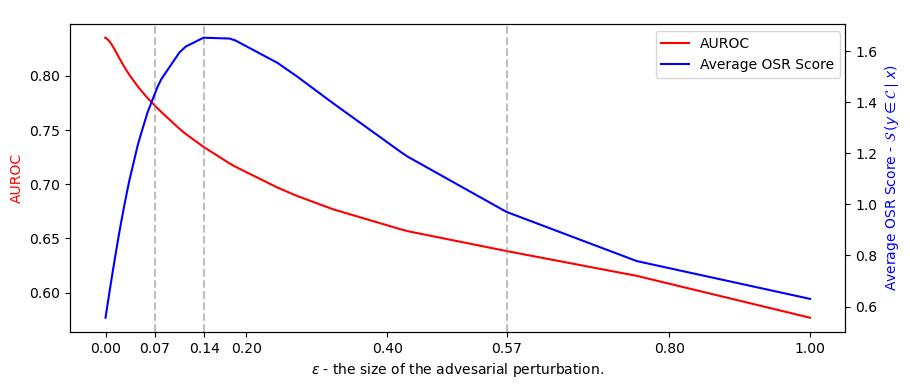

In [6]:
eps_exp_1 = EpsExperimentPlot(which_lines='both', add_zoom=False)
eps_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True)
eps_exp_1.set_legend_and_highlight_eps([-15, -11, -3], legend_loc=(0.72, 0.8))
eps_exp_1.show_and_save()

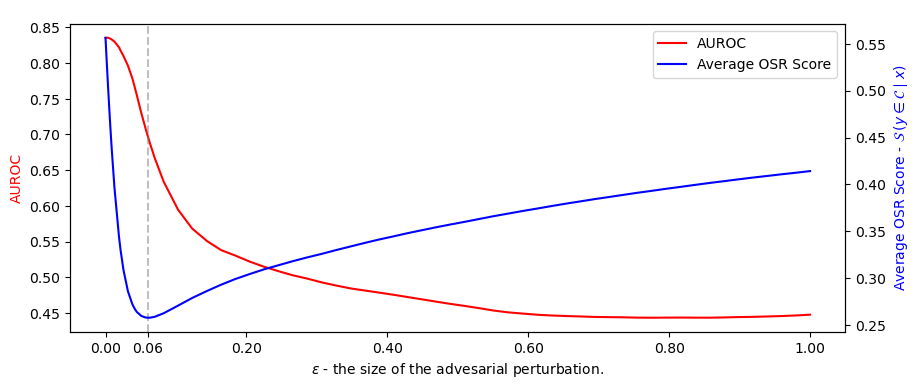

In [56]:
eps_exp_2 = EpsExperimentPlot(add_zoom=False)
eps_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True)
eps_exp_2.set_legend_and_highlight_eps([23], legend_loc=(0.71,0.8))
eps_exp_2.show_and_save()

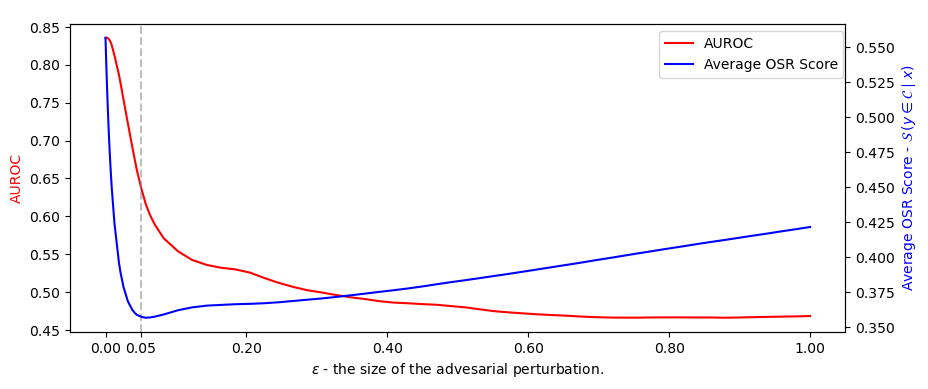

In [57]:
eps_exp_3 = EpsExperimentPlot(add_zoom=False)
eps_exp_3.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True)
eps_exp_3.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_3.show_and_save()

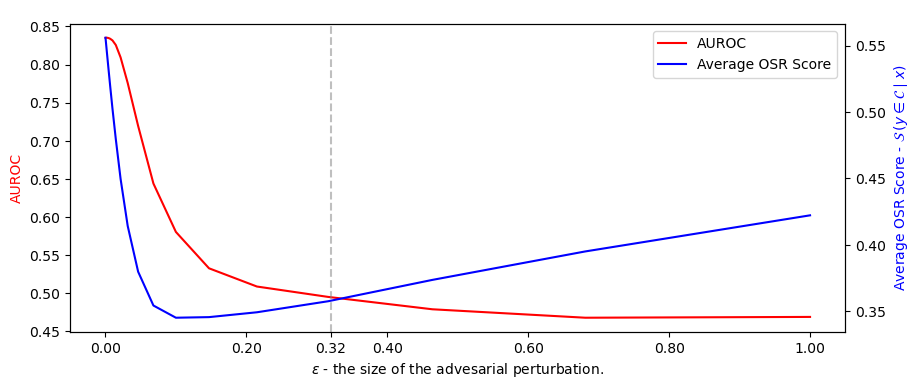

In [58]:
eps_exp_4 = EpsExperimentPlot(add_zoom=False)
eps_exp_4.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True)
eps_exp_4.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_4.show_and_save()

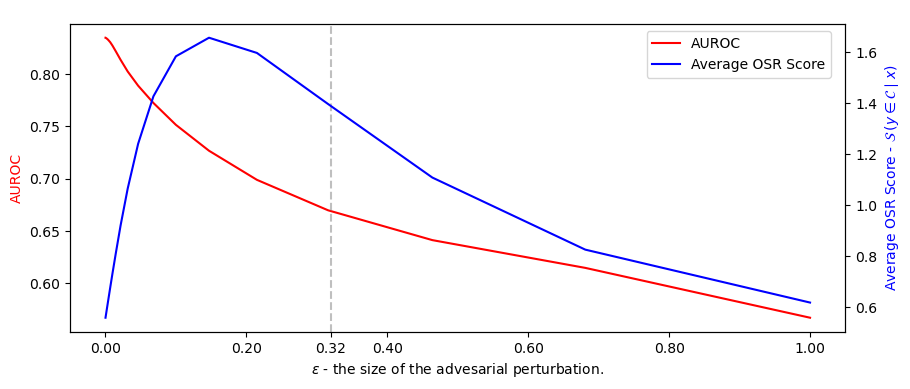

In [59]:
eps_exp_4 = EpsExperimentPlot(add_zoom=False)
eps_exp_4.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True)
eps_exp_4.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_4.show_and_save()

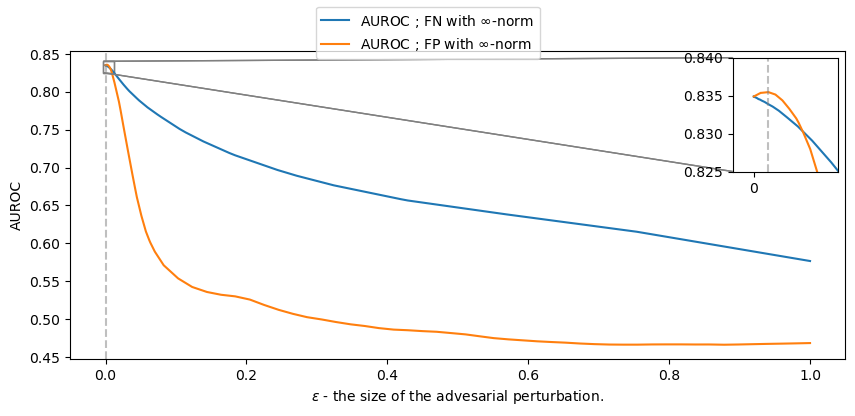

In [60]:
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC')
comparison_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
# comparison_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
# comparison_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
comparison_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
# comparison_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp_1.set_legend_and_highlight_eps(legend_loc='upper center', eps_idxs = [4])
comparison_exp_1.show_and_save()

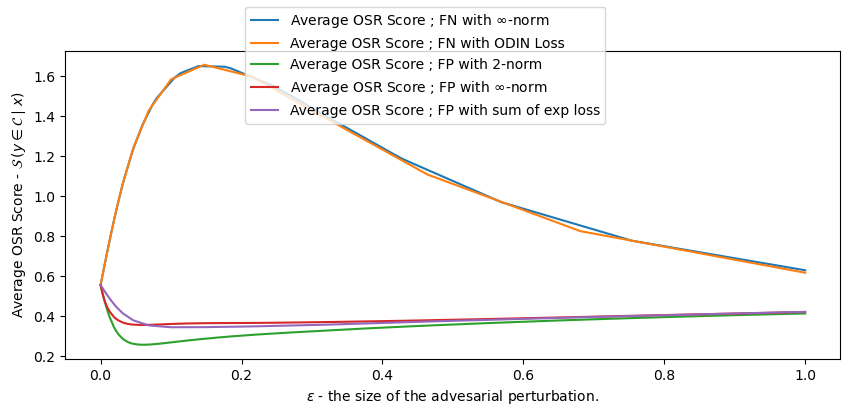

In [61]:
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
comparison_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
comparison_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
comparison_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
comparison_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
comparison_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp_2.set_legend_and_highlight_eps(legend_loc='upper center')
comparison_exp_2.show_and_save()

### Plotting the adversarial perturbations

In [62]:
eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, dataset_name='tinyimagenet', balance=True, return_avg_mls=True)
aurocs = [x[1] for x in roc_stats]

In [63]:
fn_goldfish_eps_zip_steps_0 = [fn_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True)
                          for ep in eps]
fn_goldfish_eps_0, fn_goldfish_eps_steps_0 = [x for x, _ in fn_goldfish_eps_zip_steps_0], [x for _, x in fn_goldfish_eps_zip_steps_0]

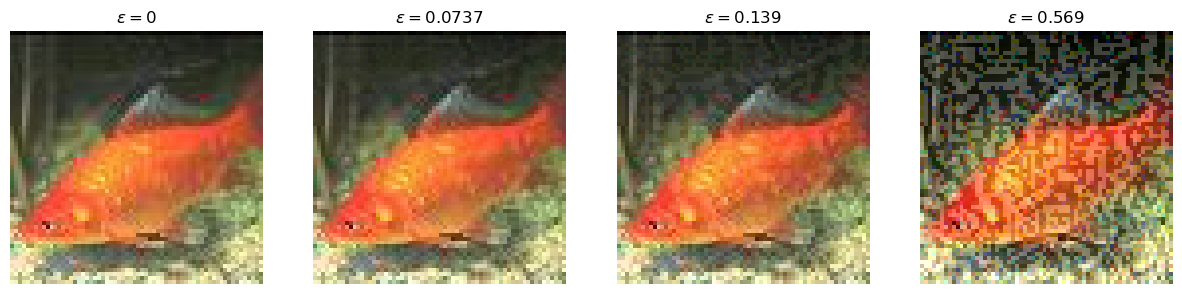

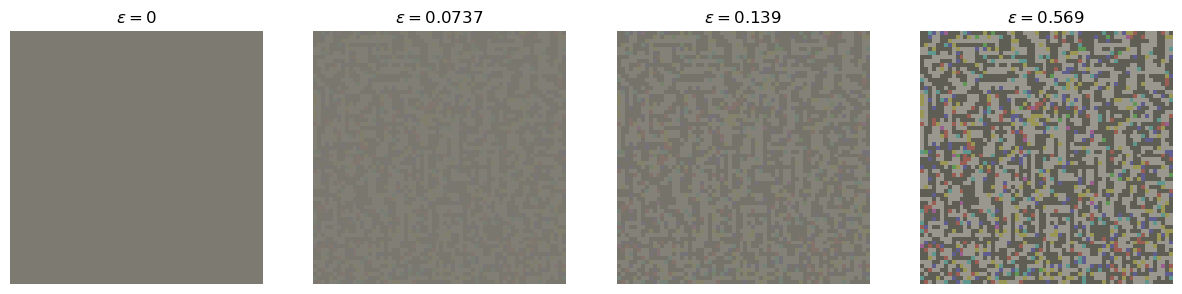

In [64]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
# eps_idxs = [-24, -11, -1]
eps_idxs = [-15, -11, -3]
chosen_eps = [eps[i] for i in eps_idxs]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fn_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
plt.savefig(root_dir + 'visualizations/goldfish_fn_fgsm.png', transparent=True, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fn_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
plt.savefig(root_dir + 'visualizations/goldfish_fn_fgsm_pertubation.png', transparent=True, bbox_inches='tight')
plt.show()
# plot_image(fn_goldfish_eps_steps_0[9][0], mean=tin_mean, std=tin_std)
# plot_image(fn_goldfish_eps_steps_0[44][0], mean=tin_mean, std=tin_std)
# plot_image(fn_goldfish_eps_steps_0[-1][0], mean=tin_mean, std=tin_std)


In [65]:
eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, dataset_name='tinyimagenet', balance=True, return_avg_mls=True)
aurocs = [x[1] for x in roc_stats]

In [66]:
fp_two_goldfish_eps_zip_steps_0 = [fp_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True, norm_ord=None)
                          for ep in eps]
fp_two_goldfish_eps_0, fp_two_goldfish_eps_steps_0 = [x for x, _ in fp_two_goldfish_eps_zip_steps_0], [x for _, x in fp_two_goldfish_eps_zip_steps_0]

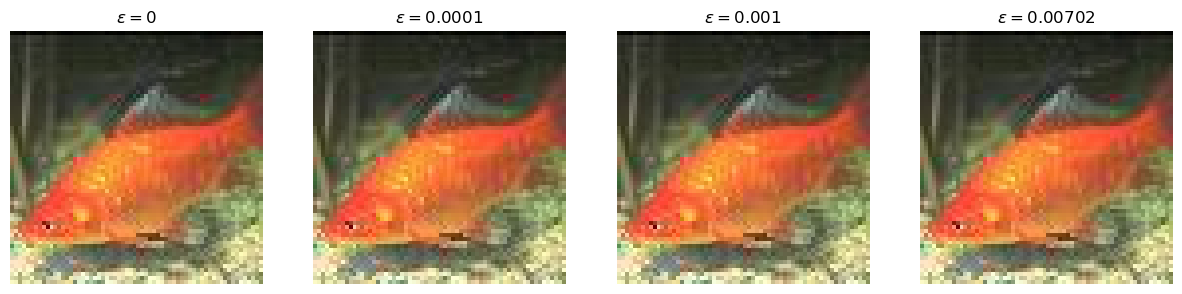

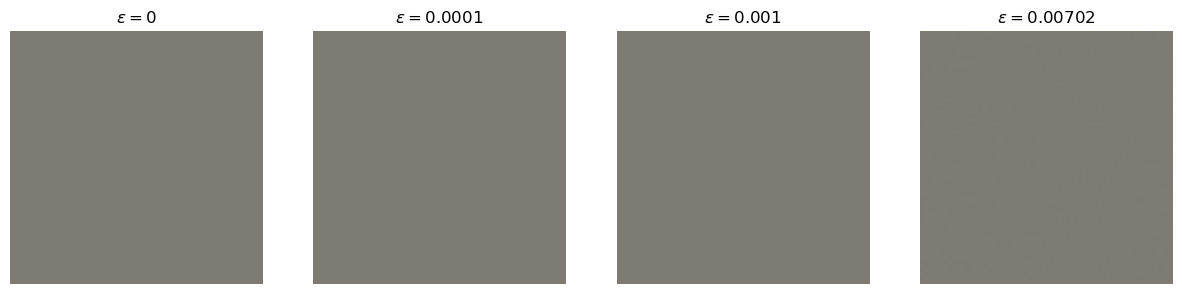

In [67]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
# eps_idxs = [-24, -11, -1]
eps_idxs = [1, 2, 10]
chosen_eps = [eps[i] for i in eps_idxs]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_two_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_two_fgsm.png', transparent=True, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_two_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_two_fgsm_pertubation.png', transparent=True, bbox_inches='tight')
plt.show()

#### Infinity norm

In [68]:
eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, dataset_name='tinyimagenet', balance=True, return_avg_mls=True)
aurocs = [x[1] for x in roc_stats]

In [69]:
fp_inf_goldfish_eps_zip_steps_0 = [fp_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True, norm_ord=torch.inf)
                          for ep in eps]
fp_inf_goldfish_eps_0, fp_inf_goldfish_eps_steps_0 = [x for x, _ in fp_inf_goldfish_eps_zip_steps_0], [x for _, x in fp_inf_goldfish_eps_zip_steps_0]

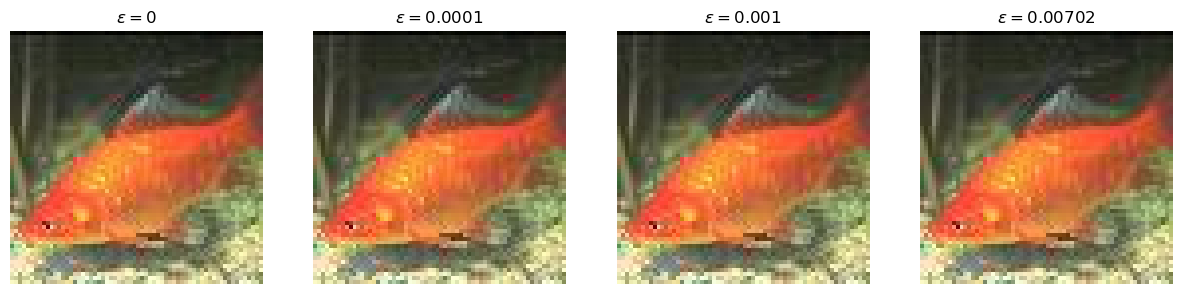

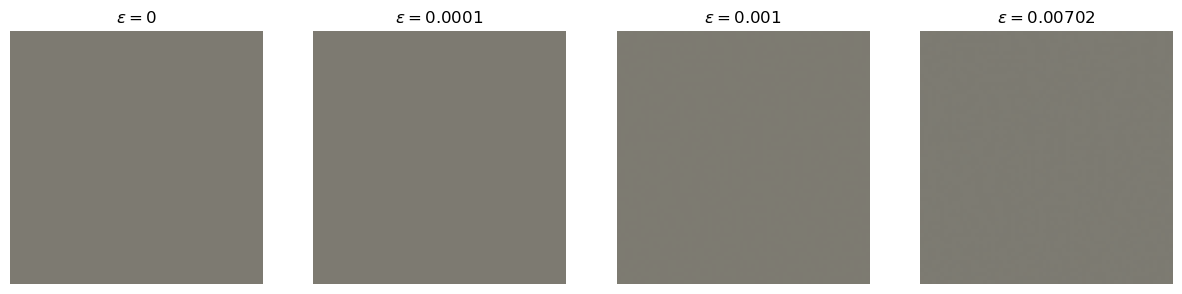

In [70]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
# eps_idxs = [-24, -11, -1]
eps_idxs = [1, 2, 10]
chosen_eps = [eps[i] for i in eps_idxs]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_inf_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_inf_fgsm.png', transparent=True, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_inf_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_inf_fgsm_pertubation.png', transparent=True, bbox_inches='tight')
plt.show()

### The effect of attacks on the ROC curve.

In [71]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet', balance=True)
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_fn = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0622/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0622/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)

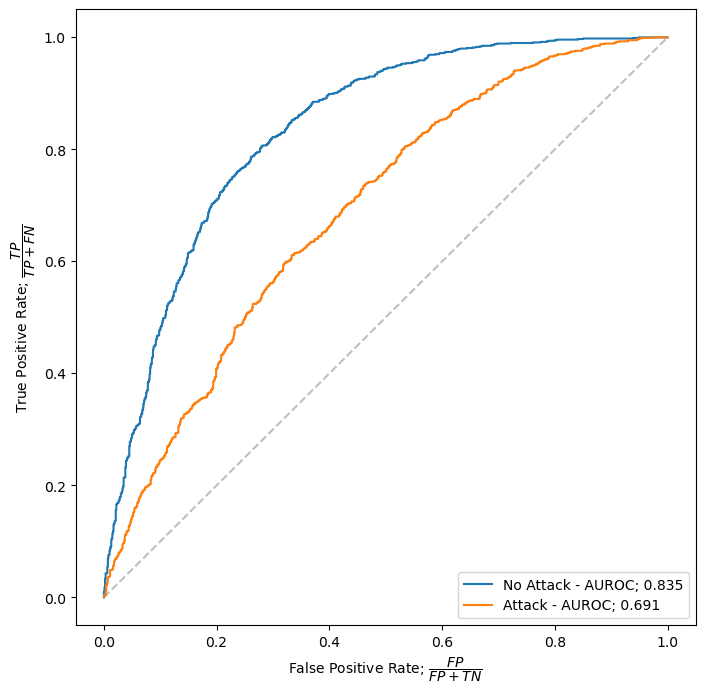

In [72]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_fn[0], label=f'Attack - AUROC; {roc_stats_fn[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='lower right')
plt.show()

### Visualizing ID vs OOD sensitivity to adversarial attacks

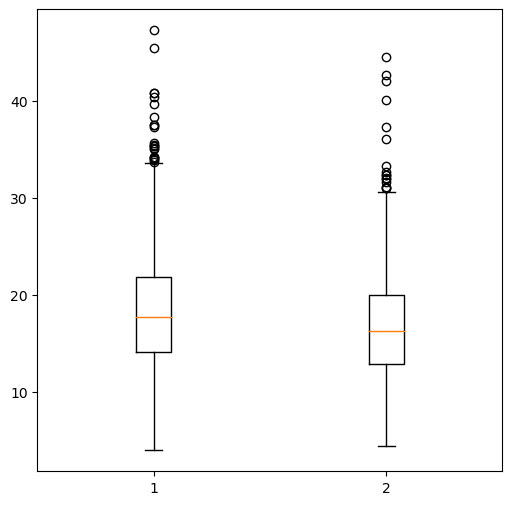

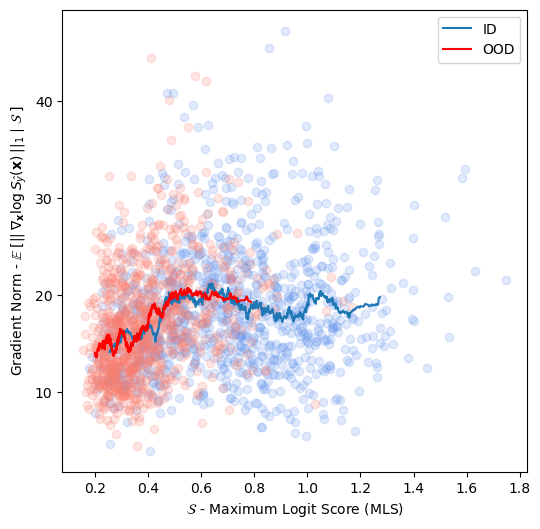

In [17]:
# Norm of log_msp gradients ID vs OOD
scatter_log_msp_grad_norms = IdOodPlot()
scatter_log_msp_grad_norms.load_grad_norm_stats(tin_grad_norm_dir + 'log_msp/', root_dir + 'logits/tinyimagenet/plain/', split_num=0, balance=True)
scatter_log_msp_grad_norms.make_boxplot()
scatter_log_msp_grad_norms.show_and_save()
scatter_log_msp_grad_norms.make_scatter_plot(window_size=25)
# scatter_log_msp_grad_norms.ax.set_ylabel(r'Gradient Norm - $||\:\nabla_{\bf{x}} \log S_{\hat{y}}({\bf{x}}) \:||_1$')
scatter_log_msp_grad_norms.set_legend()
scatter_log_msp_grad_norms.show_and_save()

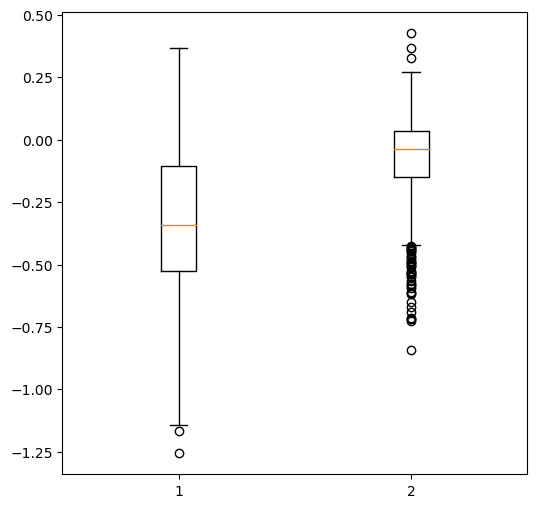

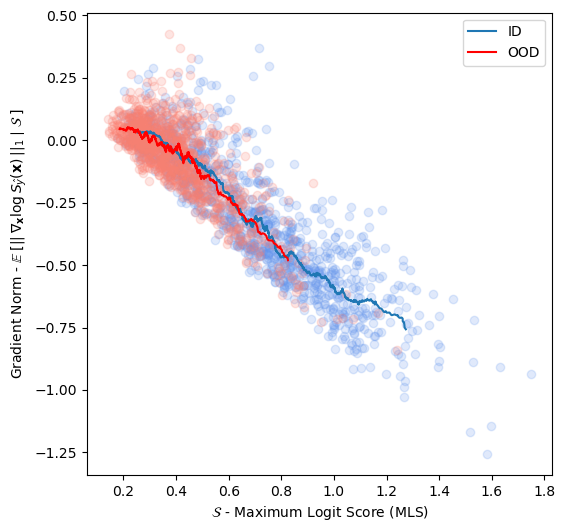

In [16]:
# Norm of log_msp gradients ID vs OOD
scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/fgsm/inf_norm/eps_0.0509/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save()
scatter_mls_diffs.make_scatter_plot(window_size=25)
# scatter_log_msp_grad_norms.ax.set_ylabel(r'Gradient Norm - $||\:\nabla_{\bf{x}} \log S_{\hat{y}}({\bf{x}}) \:||_1$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save()

### Grad Norm stat

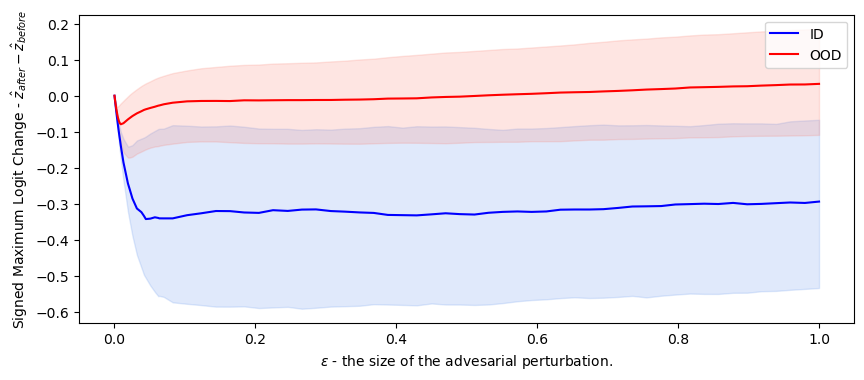

In [7]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/inf_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4))


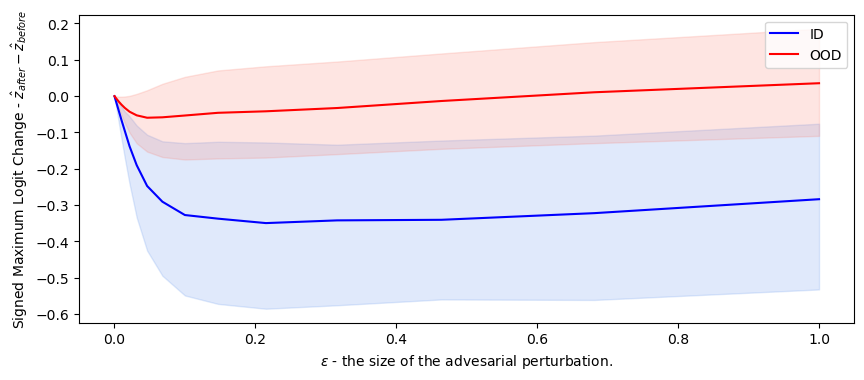

In [9]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/sum_exp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4))


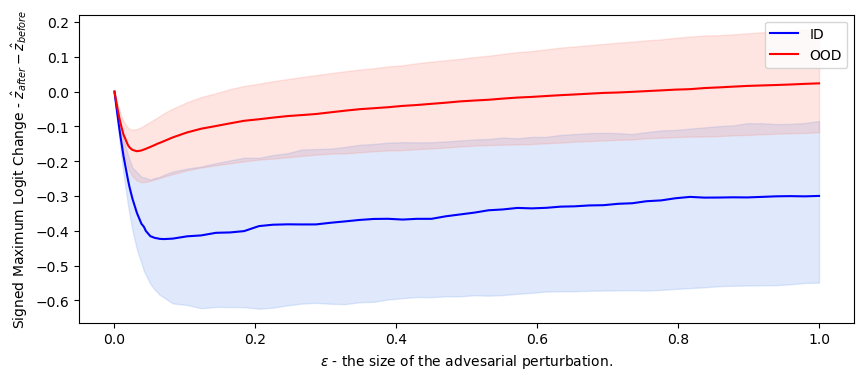

In [10]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4))


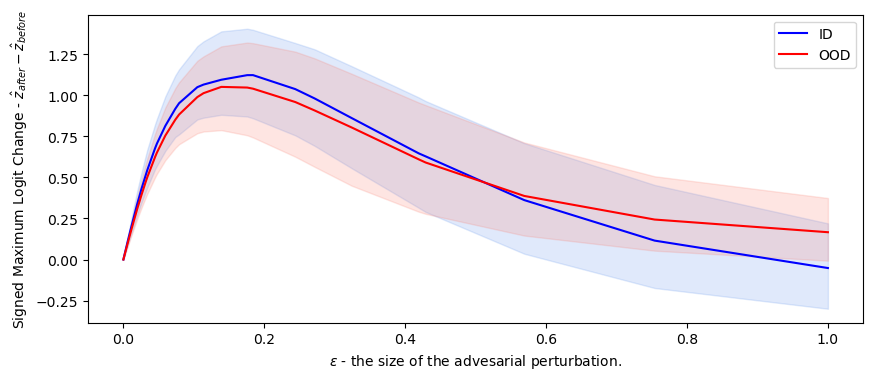

In [11]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/inf_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4))


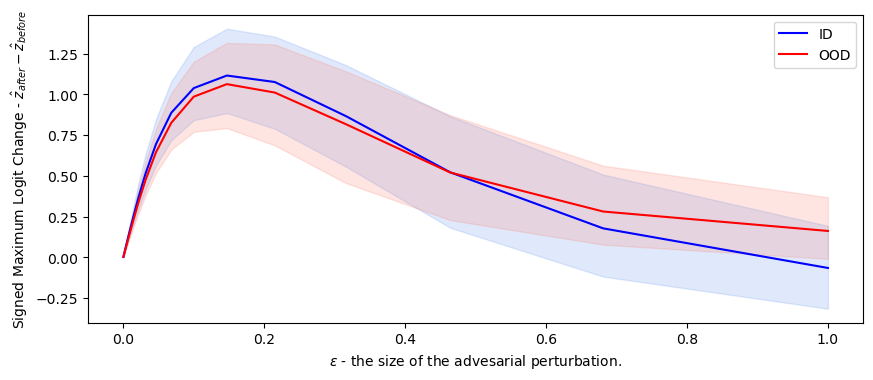

In [13]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/log_msp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4))


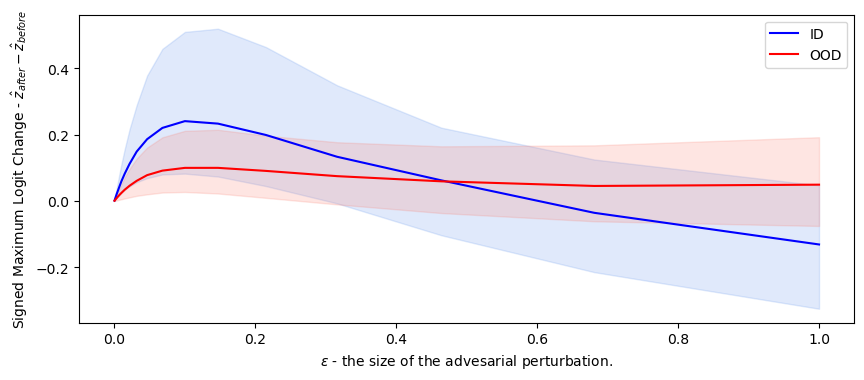

In [14]:
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/sum_exp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4))
